# Computer-Assisted Design of Genetic Circuits
by: Thad Avery, Vikram Aulakh, Samuel Peccoud<br>
github of project: https://github.com/sjpeccoud/ML_Project

### Introduction
We are trying to predict the effectiveness of a genetically encoded toggle switch. The toggle switch will consist of two DNA strands whose make proteins will bind to the other respective DNA strand when in a certain environment. One environment is an antibiotic solution which will allow the first protein to inhibit the second protein. The second environment is a sugar solution which will allow the second protein to inhibit the first first protein. One of the proteins is fluorescent which will indicate which state the toggle switch is in. Each DNA strand consists of the following segments: a promoter, a RBS and a gene. Each of these parts have different variants which affect the performance of the toggle switch.


Conner King, a PhD student in Biology, is using a mechanistic model to simulate the fluorescence of the toggle switch in the different environments. This is very computationally expensive so we were tasked to optimize this process.
Multiple machine learing techniques are used to estimate which combination of variants within the DNA strands will result in the most effective toggle switch. This project was completed in collaboration with Jean Peccoud, a professor in CBE at CSU, and Conner King.

In [5]:
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras import layers

In [6]:
import seaborn as sns

### The Data - Samuel

For this project, we were supplied multiple data files from Connor. Each data file adds more and more complexity to the project in the form of noise or added variants. The data is formatted with a string of capital letters representing different variants of a specific gene. Each gene is represented by the index of the letter in the string. Because each variant is completely different from one another, we one-hot encoded the values. This ensured that A would not be considered closer to B than C by the model. Each string of variants maps to an objective function value which is a function that processes the fluorescence of each DNA molecule and calculates a score for how well the molecule acts like a toggle switch. The closer the objective function value is to zero the better the performance. We also got rid of outlier data by removing values above a certain threshold.

The first data file has only two variants for 16 genes. The second file has three variants for 16 genes, and the third file is the same as the second except with artificial noise added to simulate real lab experiment conditions.

In [7]:
"""These are the diffrent data files that we were supplied"""
df = pd.read_csv('variants_with_obj_function.csv')
# df = pd.read_csv('3vars_18pars_obj_function_ouputs.csv')
#df = pd.read_csv('noise_3vars_18pars_obj_function_ouputs.csv')

In [8]:
stats = df['Objective Function Value'].describe()
print(stats)

count    65536.000000
mean        17.499449
std        107.695696
min          0.450787
25%          3.298123
50%          7.205768
75%         16.909123
max       6099.281288
Name: Objective Function Value, dtype: float64


In [9]:
# Parse data file for model
print("Original Shape", df.shape)
# Add 16 new columns to the front of the DataFrame
for i in range(16):
    col_name = 'Variant{}'.format(i+1)
    df.insert(i, col_name, df['Variant Combination'])
    df[col_name] = df[col_name].str.slice(i, i+1) # IF need to change A to 1 and B to 0 make it here
#     df[col_name] = df[col_name].replace({'A': -1, 'B': 1})
    
df = df.drop(columns=['Unnamed: 0', 'replicate', 'Variant Combination'])

df = df.loc[df['Objective Function Value'] <= 10]

df_encoded = pd.get_dummies(df, columns=['Variant1', 'Variant2', 'Variant3', 'Variant4', 'Variant5', 'Variant6', 'Variant7', 'Variant8', 'Variant9', 'Variant10', 'Variant11', 'Variant12', 'Variant13', 'Variant14', 'Variant15', 'Variant16'])

print("Original Shape", df_encoded.shape)
print(df_encoded)

Original Shape (65536, 4)
Original Shape (39894, 33)
       Objective Function Value  Variant1_A  Variant1_B  Variant2_A   
18                     5.414224        True       False        True  \
22                     5.414222        True       False        True   
26                     5.414243        True       False        True   
30                     5.414230        True       False        True   
48                     8.702512        True       False        True   
...                         ...         ...         ...         ...   
65531                  2.970487       False        True       False   
65532                  2.975706       False        True       False   
65533                  2.985979       False        True       False   
65534                  2.919980       False        True       False   
65535                  2.970328       False        True       False   

       Variant2_B  Variant3_A  Variant3_B  Variant4_A  Variant4_B  Variant5_A   
18          F

In [10]:
stats = df['Objective Function Value'].describe()
print(stats)

count    39894.000000
mean         4.385084
std          2.457610
min          0.450787
25%          2.360570
50%          3.820216
75%          6.116415
max          9.997900
Name: Objective Function Value, dtype: float64


Data test split and transforming/Normalization data:
The variable y is transformed into two additional variables y_sqrt and y_log by applying the square root and natural logarithm functions. This was done as the data is skewed heavily on the left and spans a big range. After the scaling the data is more distributed and not as large of an objective function range.

In [11]:
# Split data into training and testing sets
X = df_encoded.drop(['Objective Function Value'], axis=1)
y = df_encoded['Objective Function Value']

# transforming the data set with sqrt and a log function
y_sqrt = np.sqrt(y)
y_log = np.log(y + 1)


# split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape

(31915, 32)

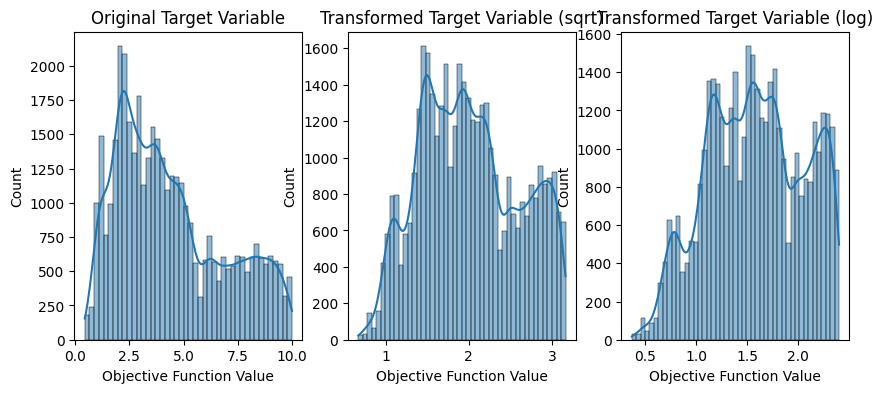

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(10, 4))
sns.histplot(y, ax=axes[0], kde=True)
axes[0].set_title('Original Target Variable')

sns.histplot(y_sqrt, ax=axes[1], kde=True)
axes[1].set_title('Transformed Target Variable (sqrt)')

sns.histplot(y_log, ax=axes[2], kde=True)
axes[2].set_title('Transformed Target Variable (log)')


plt.show()

## Training Models

First there was the attempt to use lower level ML models to see if the data could be learned on. Support vector machine and Random Forest two very strong ML models. We wanted to see how the model preformed and if the data could be learned on we wanted to use other models.

<br><br>
Overview of Results:<br>
Compared different ML models: SVM / Random Forest / Neural Network
Best model: Neural Network
Compared different signals: no error, signal plus noise, stochastic signals
Reduce the quantity of the training data to improve practicality

## Support Vector Machine (SVM) - Vikram

In [10]:
# Train the model
regressor = SVR(kernel='poly')
regressor.fit(X_train, y_train)
# Predict on test set
y_pred = regressor.predict(X_test)

In [11]:
# Compute mean squared error
mse = mean_squared_error(y_test, y_pred)
print('MSE:', mse)

MSE: 3.6097391509779695


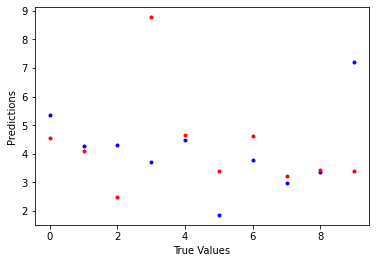

In [12]:
num = 10
plt.plot(range(num), y_test[:num], '.', color='blue')
plt.plot(range(num), y_pred[:num], '.', color='red')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()

SVM results:
On the train test split SVM produced a MSE of 1.7-3.6 depending on the data set and hyperparameters. The actual values are in blue and the predicted values are in red. It performed well with a decent accuracy but it was not the best. There was still too much error for a practical sense and did not produce a good switch set of variants when we presented the results to Conner.

## Random Forest Regressor (RF) - Vikram

In [13]:
# Initialize a Random Forest Regressor model
rf = RandomForestRegressor()

In [14]:
# Define the hyperparameters and their range of values
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'max_features': ['sqrt', 'log2']
}

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit the GridSearchCV object on the training data
grid_search.fit(X, y)

print("Best hyperparameters: ", grid_search.best_params_)
print("Root Mean Squared Error (after hyperparameter tuning): ", np.sqrt(-grid_search.best_score_))

Best hyperparameters:  {'max_depth': 10, 'max_features': 'log2', 'min_samples_split': 2, 'n_estimators': 100}
Root Mean Squared Error (after hyperparameter tuning):  2.475010035803795


In [15]:
rf = RandomForestRegressor(n_estimators=100, max_depth=10, max_features='log2', min_samples_split=10, random_state=200)

# Train the model on the training set
rf.fit(X_train, y_train)

# Predict on the test set
y_pred = rf.predict(X_test)

# Calculate the RMSE of the model on the test set
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print('MSE:', rmse**2)


cv_scores = cross_val_score(rf, X, y, cv=5, scoring='neg_mean_squared_error')
cv_scores_sqrt = cross_val_score(rf, X, y_sqrt, cv=5, scoring='neg_mean_squared_error')
cv_scores_log = cross_val_score(rf, X, y_log, cv=5, scoring='neg_mean_squared_error')


rmse_scores = -cv_scores
rmse_scores_sqrt = -cv_scores_sqrt
rmse_scores_log = -cv_scores_log

rmse = rmse_scores.mean()
rmse_sqrt = rmse_scores_sqrt.mean()
rmse_log = rmse_scores_log.mean()
print('RMSE:', rmse)
print('RMSE sqrt:', rmse_sqrt)
print('RMSE log:', rmse_log)

MSE: 2.6785650939986434
RMSE: 6.196075821060783
RMSE sqrt: 0.33047139352644134
RMSE log: 0.20028087030970831


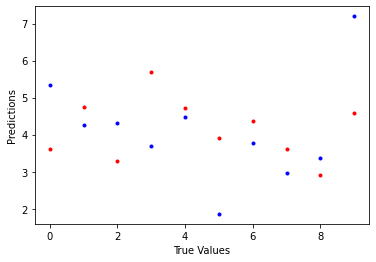

In [16]:
# Plot MSE
plt.plot(range(10), y_test[:10], '.', color='blue')
plt.plot(range(10), y_pred[:10], '.', color='red')

plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()

RF results: <br>
Random forest was another ML model that was tested. It performs similarly to SVM with MSE values of 1.7-2.7 depending on the data set and hyperparameters.  A Gradient search is performed on the RF to optimize the hyper parameters for the model as the parameters change when the data changes. A similar approach was done on SVM but it takes a very long time to run. 

For the data – variants_with_obj_function.csv
The Best hyperparameters:  {'max_depth': 10, 'max_features': 'log2', 'min_samples_split': 2, 'n_estimators': 100}
With a RMSE of:  2.475

In [17]:
# Fit a random forest model
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

# Extract feature importances
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
for f in range(X_train.shape[1]):
    print("%d. %s (%f)" % (f + 1, X_train.columns[indices[f]], importances[indices[f]]))

Feature ranking:
1. Variant4_A (0.045006)
2. Variant6_A (0.042904)
3. Variant4_B (0.042044)
4. Variant11_A (0.041754)
5. Variant10_B (0.041541)
6. Variant6_B (0.041442)
7. Variant7_B (0.041340)
8. Variant3_B (0.041259)
9. Variant10_A (0.041178)
10. Variant3_A (0.041055)
11. Variant11_B (0.040944)
12. Variant5_A (0.040790)
13. Variant7_A (0.040562)
14. Variant5_B (0.039664)
15. Variant9_A (0.037939)
16. Variant9_B (0.037853)
17. Variant8_B (0.037677)
18. Variant2_A (0.037459)
19. Variant8_A (0.036745)
20. Variant1_A (0.034169)
21. Variant12_B (0.031417)
22. Variant2_B (0.027914)
23. Variant12_A (0.026512)
24. Variant1_B (0.026319)
25. Variant15_B (0.017074)
26. Variant15_A (0.016915)
27. Variant16_A (0.016332)
28. Variant16_B (0.016230)
29. Variant13_B (0.004804)
30. Variant13_A (0.004795)
31. Variant14_B (0.004228)
32. Variant14_A (0.004134)


Wanted to see if RF could identify variants that were important to the model but the rankings assigned to the variants are so low that there is not really a conclusion that can be determined as there are no variants that heavily change the results of the outcome. A similar variant mapping was done on the MLP NN below but was not able to get it done in time for the report. The problem for the NN was trying to parc through the layers is hard due to each layer having a variation of widths.

## CNN - Thad

The CNN model is defined using the sequential model architecture. The model is trained and compiled. An early stopping callback is used to stop the model as soon as performance stops increasing to prevent long runtimes on poor-performing models. 

In [21]:
df = pd.read_csv('Rep1_objective_function_outputs.csv')

# Add 16 new columns to the front of the DataFrame
for i in range(16):
    col_name = 'Variant{}'.format(i+1)
    df.insert(i, col_name, df['Variant Combination'])
    df[col_name] = df[col_name].str.slice(i, i+1) # IF need to change A to 1 and B to 0 make it here
    df[col_name] = df[col_name].replace({'A': 0, 'B': 1})
    
df = df.drop(columns=['Unnamed: 0', 'replicate', 'Variant Combination'])

df = df.loc[df['Objective Function Value'] <= 10]

print(df)

       Variant1  Variant2  Variant3  Variant4  Variant5  Variant6  Variant7  \
0             0         0         0         0         0         0         0   
1             0         0         0         0         0         0         0   
2             0         0         0         0         0         0         0   
3             0         0         0         0         0         0         0   
4             0         0         0         0         0         0         0   
...         ...       ...       ...       ...       ...       ...       ...   
65531         1         1         1         1         1         1         1   
65532         1         1         1         1         1         1         1   
65533         1         1         1         1         1         1         1   
65534         1         1         1         1         1         1         1   
65535         1         1         1         1         1         1         1   

       Variant8  Variant9  Variant10  Variant11  Va

Epoch 1/50
3289/3289 [==============================] - 3s 706us/step - loss: 3.4690 - val_loss: 3.0532
Epoch 2/50
3289/3289 [==============================] - 2s 673us/step - loss: 3.1143 - val_loss: 3.0103
Epoch 3/50
3289/3289 [==============================] - 2s 670us/step - loss: 3.0679 - val_loss: 2.9672
Epoch 4/50
3289/3289 [==============================] - 2s 674us/step - loss: 2.9916 - val_loss: 2.9600
Epoch 5/50
3289/3289 [==============================] - 2s 678us/step - loss: 3.0321 - val_loss: 2.9613
Epoch 6/50
3289/3289 [==============================] - 2s 684us/step - loss: 3.0196 - val_loss: 2.9500
Epoch 7/50
3289/3289 [==============================] - 2s 683us/step - loss: 3.0092 - val_loss: 2.9432
Epoch 8/50
3289/3289 [==============================] - 2s 689us/step - loss: 3.0117 - val_loss: 2.9506
Epoch 9/50
3289/3289 [==============================] - 2s 695us/step - loss: 2.9539 - val_loss: 2.9428
Epoch 10/50
3289/3289 [==============================] - 2s 701u

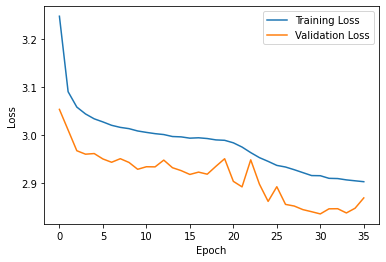

In [22]:
X_CNN = df.iloc[:, :-1].to_numpy()
y_CNN = df.iloc[:, -1].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X_CNN, y_CNN, test_size=0.2, random_state=42)

X_train_reshape_val = X_train.shape[0]
X_test_reshape_val = X_test.shape[0]


# model
model = tf.keras.Sequential([
    layers.Conv1D(8, kernel_size=3, activation='relu', input_shape=(16, 1)),
    layers.MaxPooling1D(pool_size=2),
    layers.Flatten(),
    layers.Dense(4, activation='relu'),
    layers.Dense(1)
])

# compile
model.compile(optimizer='adam', loss='mse')

# train
early_stopping = tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss')
history = model.fit(X_train.reshape((X_train_reshape_val, 16, 1)), y_train, epochs=50, batch_size=15,
                    validation_data=(X_test.reshape((X_test_reshape_val, 16, 1)), y_test), callbacks=[early_stopping])

mse = model.evaluate(X_test.reshape((X_test_reshape_val, 16, 1)), y_test)
print("Mean Squared Error: ", mse)

y_pred = model.predict(X_test.reshape((X_test_reshape_val, 16, 1)))


# Plot the training and validation loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

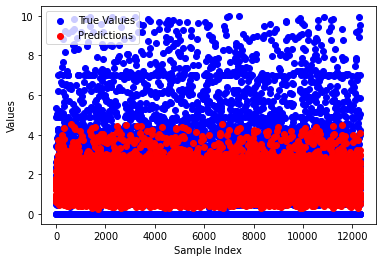

In [23]:
#plot results
plt.scatter(range(len(y_test)), y_test, c='b', label='True Values')
plt.scatter(range(len(y_pred)), y_pred, c='r', label='Predictions')
plt.xlabel('Sample Index')
plt.ylabel('Values')
plt.legend()
plt.show()

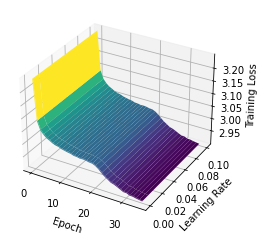

In [24]:
from mpl_toolkits import mplot3d

learning_rates = [0.1, 0.01, 0.001, 0.0001, 0.00001]
train_loss = []

for lr in learning_rates:
    # define, compile, and train the model with current learning rate lr
    
    # append the train loss history to the train_loss list
    train_loss.append(history.history['loss'])

# convert train_loss list to numpy array for plotting
train_loss = np.array(train_loss)

train_loss = history.history['loss']
num_epochs = len(train_loss)

# Create a 3D grid of points for the surface plot
x = np.linspace(0, num_epochs, num_epochs)
y = np.linspace(0, 1, 20)
X, Y = np.meshgrid(x, y)

# Create a 3D plot of the loss function surface
fig = plt.figure()
ax = plt.axes(projection='3d')
X, Y = np.meshgrid(range(len(train_loss)), learning_rates)
ax.plot_surface(X, Y, np.tile(train_loss, (len(learning_rates), 1)), cmap='viridis')
ax.set_xlabel('Epoch')
ax.set_ylabel('Learning Rate')
ax.set_zlabel('Training Loss')
plt.show()

The CNN regression model for our data was not the best model we created. The CNN had a hard time performing because this data did not have great spacial relationships, and all of the data was in a close range. The model had a hard time finding important features from the dataset.

## Neural Network or MLP - Samuel and Thad
For the neural network, we used tensorflow to create layers and define the structure of the model. The data is reimported below to have it correctly formatted for tensorflow.

In [54]:
# Parse data file for model
df = pd.read_csv('variants_with_obj_function.csv')
print("Original Shape", df.shape)
# Add 16 new columns to the front of the DataFrame
for i in range(16):
    col_name = 'Variant{}'.format(i+1)
    df.insert(i, col_name, df['Variant Combination'])
    df[col_name] = df[col_name].str.slice(i, i+1) # IF need to change A to 1 and B to 0 make it here
#     df[col_name] = df[col_name].replace({'A': -1, 'B': 1})
    
df = df.drop(columns=['Unnamed: 0', 'replicate', 'Variant Combination'])

df = df.loc[df['Objective Function Value'] <= 10]

df_encoded = pd.get_dummies(df, columns=['Variant1', 'Variant2', 'Variant3', 'Variant4', 'Variant5', 'Variant6', 'Variant7', 'Variant8', 'Variant9', 'Variant10', 'Variant11', 'Variant12', 'Variant13', 'Variant14', 'Variant15', 'Variant16'])

print("Original Shape", df_encoded.shape)
print(df_encoded)

X = df_encoded.drop(['Objective Function Value'], axis=1)
y = df_encoded['Objective Function Value']
y_sqrt = np.sqrt(y)
y_log = np.log(y + 1)

Original Shape (65536, 4)
Original Shape (39894, 33)
       Objective Function Value  Variant1_A  Variant1_B  Variant2_A  \
18                     5.414224           1           0           1   
22                     5.414222           1           0           1   
26                     5.414243           1           0           1   
30                     5.414230           1           0           1   
48                     8.702512           1           0           1   
...                         ...         ...         ...         ...   
65531                  2.970487           0           1           0   
65532                  2.975706           0           1           0   
65533                  2.985979           0           1           0   
65534                  2.919980           0           1           0   
65535                  2.970328           0           1           0   

       Variant2_B  Variant3_A  Variant3_B  Variant4_A  Variant4_B  Variant5_A  \
18           

The create_mlp function is used to automatically adjust the size of the model based on the input shape. The create_structure function makes an array of values that define the shape of the hidden layers.

In [55]:
# Define the MLP model
def create_mlp(input_dim, structure, output_dim):
    model = Sequential()
    
    for i in range(len(structure)):
        if (i == 0):
            model.add(Dense(structure[0], input_dim=input_dim, activation='relu'))
        else:
            model.add(Dense(structure[i], input_dim=structure[i-1], activation='relu'))
    
    
    model.add(Dense(output_dim, activation='linear'))
    return model

def create_structure(input_dim, output_dim, depth):
    structure_dec = []
    structure_round = []
    
    for i in range(depth):
        new_layer_hidden = 0
        if (len(structure_dec) > 0):
            new_layer_hidden = (structure_dec[-1] * (2/3)) + output_dim
        else:
            new_layer_hidden = (input_dim * (2/3)) + output_dim
        structure_dec.append(new_layer_hidden)
        
    for val in structure_dec:
        structure_round.append(round(val))
    return structure_round

The neural network is created and trained below using GPU optimization to speed up the training. 

Neural Network structure: [22, 16, 12, 9, 7]
Epoch 1/100
798/798 [==============================] - 1s 870us/step - loss: 0.4600 - mse: 0.4600 - val_loss: 0.1659 - val_mse: 0.1659
Epoch 2/100
798/798 [==============================] - 1s 738us/step - loss: 0.1338 - mse: 0.1338 - val_loss: 0.1497 - val_mse: 0.1497
Epoch 3/100
798/798 [==============================] - 1s 744us/step - loss: 0.1068 - mse: 0.1068 - val_loss: 0.1275 - val_mse: 0.1275
Epoch 4/100
798/798 [==============================] - 1s 738us/step - loss: 0.0734 - mse: 0.0734 - val_loss: 0.0920 - val_mse: 0.0920
Epoch 5/100
798/798 [==============================] - 1s 743us/step - loss: 0.0404 - mse: 0.0404 - val_loss: 0.0817 - val_mse: 0.0817
Epoch 6/100
798/798 [==============================] - 1s 739us/step - loss: 0.0305 - mse: 0.0305 - val_loss: 0.0531 - val_mse: 0.0531
Epoch 7/100
798/798 [==============================] - 1s 743us/step - loss: 0.0258 - mse: 0.0258 - val_loss: 0.0505 - val_mse: 0.0505
Epoch 8/10

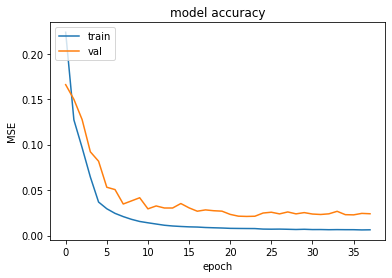

,Structure,Val MSE,Epochs
0,"[22, 16, 12, 9, 7]",0.023918,38


In [56]:
data = []

#Use the y_log data
X_train = X
y_train = y_log

input_dim = X_train.shape[1]
output_dim = 1
depth = 5

structure = create_structure(input_dim, output_dim, depth)
print("Neural Network structure:", structure)

# Set up the session config to limit GPU memory usage
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(session)
model = 0

# Create the model
with tf.device('/GPU:0'): # specify the GPU to use
    model = create_mlp(input_dim, structure, output_dim)

    # Compile the model with an optimizer and loss function
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])

    # Train the model with early stopping
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15)
    history = model.fit(X_train, y_train, epochs=100, batch_size=40, validation_split=0.2, callbacks=[early_stop])

    plt.plot(history.history['mse'])
    plt.plot(history.history['val_mse'])
    plt.title('model accuracy')
    plt.ylabel('MSE')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    data.append([structure, history.history['val_mse'][-1], len(history.history['val_mse'])])

df = pd.DataFrame(data, columns=('Structure', 'Val MSE', 'Epochs'))
df_sorted = df.sort_values(by='Val MSE')
df_sorted

Here is a chart showing the learning of the neural network. The MSE is 0.023 which is excellent.

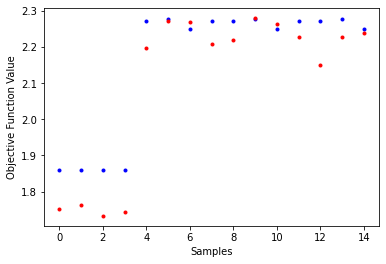

In [59]:
y_pred = model.predict(X_train)

# Plot Guesses
num = 15
plt.plot(range(num), y_train[:num], '.', color='blue')
plt.plot(range(num), y_pred[:num], '.', color='red')
plt.xlabel('Samples')
plt.ylabel('Objective Function Value')
plt.show()

The following chart displays a brief view of how the model is predicting values. The actual values are in blue and the predicted values are in red. This graph was helpful to understand what kind of error the model is producing. For the most part the model seems to guess more towards the mean of the objective function value for the dataset.

### Conclusion:
The neural network model works well with an MSE of 0.023 which far outperforms all the other models we trained. To enable Conner to use the model without having to dive too deep into the code, we created a mlp_turnkey.ipynb file where he can easily leverage the power of this model for his application. He hopes to incorporate our work in future publications.

#### Sources:

Seaborn and plt:
https://seaborn.pydata.org/tutorial/introduction
https://matplotlib.org/2.0.2/users/pyplot_tutorial.html 
<br>Pandas and numpy
https://pandas.pydata.org/
https://numpy.org/ 
<br>transforming/Normalization data:
https://developers.google.com/machine-learning/data-prep/transform/introduction#:~:text=Reasons%20for%20Data%20Transformation&text=Converting%20non%2Dnumeric%20features%20into,inputs%20to%20a%20fixed%20size.
https://developers.google.com/machine-learning/data-prep/transform/normalization 
<br>overfitting:
https://developers.google.com/machine-learning/decision-forests/overfitting-and-pruning 
<br>Svm:
https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html
https://www.geeksforgeeks.org/support-vector-regression-svr-using-linear-and-non-linear-kernels-in-scikit-learn/# 
<br>RF:
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html 
https://developers.google.com/machine-learning/decision-forests/random-forests 
https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
https://mljar.com/blog/feature-importance-in-random-forest/
CNN:<br>
https://stackoverflow.com/questions/41908379/keras-plot-training-validation-and-test-set-accuracy
https://stackoverflow.com/questions/66016931/model-fitx-train-y-train-epochs-5-validation-data-x-test-y-test-isnt-wor
https://keras.io/api/layers/convolution_layers/convolution1d/
https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D
https://www.tensorflow.org/api_docs/python/tf/keras/Sequential
https://keras.io/api/callbacks/early_stopping/
https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/
https://stackoverflow.com/questions/37661119/python-mpl-toolkits-installation-issue
https://matplotlib.org/2.2.2/mpl_toolkits/index.html
<br>Tf:
https://www.tensorflow.org/api_docs/python/tf/keras/Sequential
https://towardsdatascience.com/using-the-right-dimensions-for-your-neural-network-2d864824d0df
https://www.tensorflow.org/guide/gpu 

